<a href="https://colab.research.google.com/github/AlexandreSarmento/BooleanNetworkBioME/blob/master/rede_booleana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount your Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Restart runtime 
Just clear variables and not package

In [ ]:
exit()

# Workflow
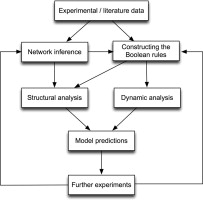

# Install Package

## PyBoolNet

In [ ]:
!wget https://github.com/hklarner/PyBoolNet/releases/download/v2.2.8/PyBoolNet-2.2.8_linux64.tar.gz
!pip3 install PyBoolNet-2.2.8_linux64.tar.gz

!pip install imgaug==0.2.5
!pip install networkx==2.2
!pip install nose

## BooleanNet

In [ ]:
#!pip3 install /content/booleannet-master.zip
!pip3 install git+https://github.com/ialbert/booleannet.git

# Biologic overview and description of the Regulatory Network

A rede compreende a interação entre oxigênio, fator de crescimento, eixo do HIF.
A rede contém: 
(1) alça de parada de ciclo celular e apoptose advinda do HIF1-a
(2) alça de sobrevivência à apoptose advinda do crosstalk entre HIF2a com mTOR.

Concordamos em criar uma rede que abarcasse um módulo de (1) ciclo celular, um módulo de (2) apoptose (via intrínseca), um módulo (3) elo (que liga apoptose e ciclo celular) e por fim, um módulos dos (4) alvos do HIF. 

Abaixo a quantidade de nós de cada módulo.
(1) 9 nós, (2) 15 nós, (3) 10 nós e (4) 4 nós. Ainda sigo trabalhndo na (2).

Penso que, agora temos uma rede que podemos refinar tanto para a inferência via dados de wet lab quanto para a rede teórica. Estou desenhando esta rede pensando nos
aspectos teóricos de modelos de glioblastoma e carcinoma renal, tal que possamos vislumbrar oportunidade de construir modelos dentro de uma série  de perspectiva que vinhamos conversando.

Portanto, abaixo explico a biologia por trás da rede 

(1) Existe uma regulação do eixo HIF dependente de O2, mas também independente de O2. A regulação dependente de O2, está relacionada ao  supressor de tumor VHL, cujo silenciamento pode deflagrar tumores renais e glioblastomas caracterizados por alta vascularizaçao.

(2) O HIF1a deflagra uma resposta aguda, enquanto que o HIF2a deflagra uma resposta crônica.

(3) A deprivação de oxigênio em tumores sólidos está associada a deprivação de fatores de crescimento. As evidencias experimentais apontam que existe uma regulação mútua entre o eixo do HIF e PI3K-Akt-mTOR, tal que mTOR pode ativar HIF2a e este último induzir a ubiqutinação dos sítios stc1 e stc2 do mTOR, na ausência de fatores de crescimento.

(4) O HIF2a quando ativado por Akt/mTOR suprime p53.

(5) A fosfolipases C, quando ativadas, induzema liberação de cálcio pelo retículo endoplasmático, este por sua vez induz a dissociação do complexo CB/p300, de modo que o p300 possa se ligar a p53 ou HIF1a. Não há evidências de que o p300 tenha interação com HIF2a.

(6) O mdm2 em hipóxia crônica se dissocia do p53. O motivo são 2: 1) existe uma interação entre HIF1a e p53 dado a competição p300. 2) O Mdm2 pode ativar programas de migração e pode degradar HIF1a (ainda existe uns dados contraditórios).

(7) Assim, os alvos do HIF1a ativam p27 e Cdh1 que são supressores de tumor e inibem alça anti apoptóticas. Por outro lado, os alvos do HIF2a ativam alça anti apoptótica e desativam supressores de tumores.

# HIF axis

# Create Network Picture

In [ ]:
import PyBoolNet

with open('/content/drive/My Drive/boolean_network_colab/HIF_axis_module_PyBoolNet.bn','r') as file:
  bnet = file.read()
primes = PyBoolNet.FileExchange.bnet2primes(bnet)
PyBoolNet.InteractionGraphs.create_image(primes,"HIFaxis_graph.png")

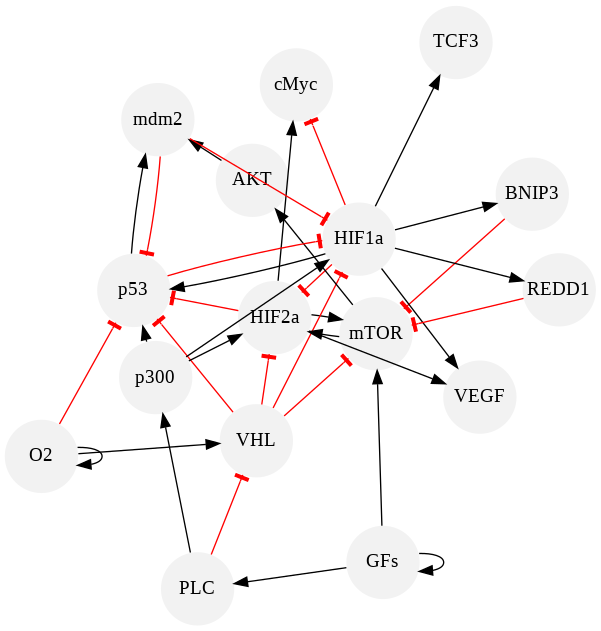

# Supporting Function and Packages Import

This supporting function regarding Booleannet package

In [ ]:
import boolean2
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
import seaborn as sns
import networkx as nx
from itertools import combinations, product
from collections import Counter

In [ ]:
def plot_state_succession(states,state_labels=None,title=None, nodes=None, fontsizex=10):

    '''
    Creates a plot of the trajectory performed by a BooleanNet model.
    
    Inputs:
    states - container of boolean2 State objects or of dictionaries equivalent to those.
    state_labels (optional) - container of strings corresponding to every state. They will be the labels on the Y axis. Default: range(len(states))
    title (optional) - the title of the plot
    nodes (optional) - the set of nodes to be whose trajectory should be plotted. The set can be a subset or identical set to the nodes in the states. If list the order of the list will be respected on the plot.
    fontsizex (optional) - the fontsize of the X axis labels (the node names). Default: 10
    
    '''
    from matplotlib import pyplot as plt
    import matplotlib
    if nodes==None:
        nodes=states[0].keys()
    state_transition=[]
    for s in states:
        state_transition.append([s[k] for k in nodes])
    cmap = matplotlib.colors.ListedColormap(['blue', 'orange'])
    steps=len(state_transition)
    plt.figure(figsize=(len(nodes),steps))
    plt.imshow(state_transition, interpolation='none',cmap=cmap)
    ax = plt.gca()
    plt.xticks(range(len(nodes)),nodes, fontsize=fontsizex)   
    if state_labels==None:
        plt.yticks(range(steps),fontsize=12)
    else:
        plt.yticks(range(steps),state_labels,fontsize=12)
    if title!=None:
        plt.title(title)
    ax.set_yticks(np.arange(-.5, steps,1),minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.show()

import random
def general_async_pick( lines ):
    data = [ random.choice( lines )]
    #print data
    return data   

class TransGraph(object):
    """
    Represents a transition graph
    """
    import networkx as nx
    def __init__(self, logfile, verbose=False):
        self.graph = nx.MultiDiGraph(  )         
        self.fp = open( logfile, 'wt')
        self.verbose = verbose
        self.seen = set()
        self.store = dict()
        self.colors = dict()

    def add(self, states, times=None):
        "Adds states to the transition"
    
        # generating the fingerprints and sto
        times = times or range(len(states))
        fprints = []
        for state in states:
            if self.verbose:
                fp = state.bin()
            else:
                fp = state.fp()
            fprints.append( fp )
            self.store[fp] = state

        self.fp.write( '*** transitions from %s ***\n' % fprints[0] )

        for head, tail, tstamp in zip(fprints, fprints[1:], times ):
            pair = (head, tail)
            self.fp.write('T=%s: %s->%s\n' %  (tstamp, head, tail) ) 
            if pair not in self.seen:
                self.graph.add_edge(head, tail)
                self.seen.add(pair)
        
    def save(self, fname, colormap={}):
        "Saves the graph as gml"
        write_gml(graph=self.graph, fname=fname, colormap=colormap)
    
        self.fp.write( '*** node values ***\n' )

        # writes the mapping
        first = self.store.values()[0]
        header = [ 'state' ] + first.keys()
        self.fp.write( util.join(header) )
        
        for fprint, state in sorted( self.store.items() ):
            line = [ fprint ]  + map(int, state.values() )
            self.fp.write( util.join(line) )
            
def read_rules_text(model_name):
    """
    A simple file reading function, that reads the BooleanNet rules text files and returns them as a string
    
    Input: 
    model_name - str, containing the name of the model, assuming the convention, that the model files are name are named "model_name".txt
    
    Returns:
    rules - str, the boolean rules contained in the file
    """
    rules_file='%s.txt'%model_name
    with open(rules_file,'r') as f:
        rules=f.read()
    rules=rules.replace('#BOOLEAN RULES','') #in some cases this line is in the file, but we don't need it
    return rules

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

def default_shuffler( lines ):
    "Default shuffler"
    temp = lines[:]
    random.shuffle( lines )
    return temp

# Environmental Input Initial Condition: 0xygen = False, GFs = False

## Cyclic Attractors Trajectory

We expect the model to be roboust enough, such that the cyclic behavior will re-emerge with general asyncronous update, as a complex attractor. The model is instatiated below, together with a plot of the trajectory, to aid the validation for the  asynchronous update scheme.

In [ ]:
model_name='HIFaxis'
rules=read_rules_text(model_name)

### syncronous

In [ ]:
initial_state={'O2':0,'GFs':0,'VHL':0,'HIF1a':0,'HIF2a':0,'p53':0,'REDD1':0,'mTOR':0,'AKT':0, \
               'mdm2':0,'PLC':0,'p300':0,'cMyc':0,'VEGF':0,'BNIP3':0,'TCF3':0}

sync_model = boolean2.Model(rules, mode='sync')
sync_model.initialize(lambda node: initial_state[node])
steps = 50
sync_model.iterate(steps)

_,cycle_length=sync_model.detect_cycles() #.detect_cycles returns the starting point and the length of a cycle
#assert cycle_length == 16
cycle_states = sync_model.states[-cycle_length:]

plot_state_succession(cycle_states)

### asyncronous

In [ ]:
initial_state={'O2':0,'GFs':0,'VHL':0,'HIF1a':0,'HIF2a':0,'p53':0,'REDD1':0,'mTOR':0,'AKT':0, \
               'mdm2':0,'PLC':0,'p300':0,'cMyc':0,'VEGF':0,'BNIP3':0,'TCF3':0}
async_model = boolean2.Model(rules, mode='async')
async_model.initialize(lambda node: initial_state[node])
steps = 20
async_model.iterate(steps, shuffler=general_async_pick)
plot_state_succession(async_model.states)

## State Transition Graph

Based on an extended random walk. To see if a complex attractor emerges we sample the STG with a random walk, expecting two things: first the number of unique states visited is much less than the number of steps taken, meaning the random walker is in a complex attractor, second, a set of states in the complex attractor should be very similar (or identical) 
to the synchronous attractor states, preferably respecting the synchronous order too.

In [ ]:
nr_of_steps=10000
start_state=cycle_states[0]
async_model.initialize(lambda node: start_state[node])
async_model.iterate(nr_of_steps,shuffler=general_async_pick)

TG=TransGraph(logfile='states_00.txt')
TG.add(async_model.states)
G=TG.graph
print("Number of unique states visited:",G.number_of_nodes())
print("Number of unique transitions:",G.number_of_edges())

In [ ]:
## Calculating some of the metrics discussed above
fp_state_dict=dict(zip(async_model.fp(),async_model.states))
overlap_to_sync_cycle={}
closest_sync_state={}
for n in G.nodes:
    async_state=fp_state_dict[n]
    overlaps=[]
    for j in range(len(cycle_states)):
        
        #async_state=dict(zip(model_async.nodes,top_PR_states[i]))
        sync_state=cycle_states[j]
        overlap=0
        for s in async_state.keys():
            if async_state[s] == sync_state[s]:
                overlap+=1.
        overlap/=len(async_state.keys())
        overlaps.append(overlap)
        
    overlap_to_sync_cycle[n]=max(overlaps)
    closest_sync_state[n]=overlaps.index(max(overlaps))

fp_states=async_model.fp()
state_occurances=Counter(fp_states)
edge_occurances=Counter([(fp_states[i-1], fp_states[i]) for i in range(len(fp_states))])

In [ ]:
plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2,with_labels=False,width=[float(edge_occurances[i])*0.1 for i in G.edges()])
lc = lc = nx.draw_networkx_labels(G,pos,{i:closest_sync_state[i] for i in G.nodes()}, font_size=16)
nc = nx.draw_networkx_nodes(G, pos, node_color=[overlap_to_sync_cycle[i] for i in G.nodes()], 
                                with_labels=[closest_sync_state[i] for i in G.nodes()], node_size=[float(state_occurances[j]) for j in G.nodes()], cmap=plt.cm.RdPu, alpha=0.7)
plt.colorbar(nc)
plt.axis('off')
plt.show()

## Static Attractor

Given a syncronous model the function initiates all 2**N initial states, where N is the number of nodes, and performs one step, adding it to a state transition graph (STG). Due to the exponential growth of the state space, with the size of the network, this can be extremely demanding for larger networks. Inputs: model_sync - boolean2 type network model initiated as synchronous, Returns: g - networx graph object.

In [ ]:
def get_sync_STG(model_sync):
    '''
    Given a syncronous model the function initiates all 2**N initial states, where N is the number of nodes, 
    and performs one step, adding it to a state transition graph (STG).
    WARNING! Due to the exponential growth of the state space, with the size of the network, 
    this can be extremely demanding for larger networks

    Inputs: model_sync - boolean2 type network model initiated as synchronous 

    Returns: g - networx graph object
    '''

    fp_state_dict={}
    tg=TransGraph(logfile='sync_states.txt')
    for init_state, some_func in boolean2.state.all_initial_states(model_sync.nodes): 

        model_sync.initialize(lambda node: init_state[node])
        model_sync.iterate(1)
        tg.add(model_sync.states)
        fp_state_dict=merge_two_dicts(fp_state_dict,dict(zip(model_sync.fp(),model_sync.states)))
    g=tg.graph
    g.remove_edges_from(g.selfloop_edges()) 
    return g,fp_state_dict

In [ ]:
sync_model = boolean2.Model(rules, mode='sync')
print('State space size:',2**len(sync_model.nodes))

In [ ]:
g,fp_state_dict=get_sync_STG(sync_model)

In [ ]:
g.remove_edges_from(g.selfloop_edges()) 
static_attractors=[]
for i in g.nodes():
    if g.out_degree(i) == 0:
        static_attractors.append(fp_state_dict[i])

In [ ]:
plot_state_succession(static_attractors, state_labels=['Attractor_%d'%i for i in range(len(static_attractors))])

## Basin

Comprises all states which lead to a corresponding attractor. From a wet-lab point of view, the analysis of basins of attraction allows hypothesizing about the underlying decision process in the modeled regulatory system. The larger the basin of attraction is the more the attractor is likely to be biologically meaningful.

## install folder and file unde package issue

In [ ]:
!apt-get install libreadline6:i386
!apt-get install libreadline-dev
#!mkdir lib
#!ln -s /lib/x86_64-linux-gnu/libreadline.so.X ./lib/libreadline.so.6
#!export LD_LIBRARY_PATH="$LD_LIBRARY_PATH:$PWD/lib/"
!cd /lib/x86_64-linux-gnu ; sudo ln -s libreadline.so.7.0 libreadline.so.6

## Call the prime implicant

In [ ]:
import PyBoolNet

with open('/content/drive/My Drive/boolean_network_colab/HIF_axis_module_PyBoolNet.bn','r') as file:
  bnet = file.read()

primes = PyBoolNet.FileExchange.bnet2primes(bnet)

#### basin asyncronous

##### weak basin

In [ ]:
attrs = PyBoolNet.Attractors.compute_json(primes,"asynchronous",FnameJson="attrs.json")
state = attrs["attractors"][0]["state"]["str"]
weak = PyBoolNet.Basins.weak_basin(primes, "asynchronous", state)
for key, value in weak.items():
  print("{} = {}".format(key, value))

##### strong basin

In [ ]:
strong = PyBoolNet.Basins.strong_basin(primes, "asynchronous", state)
for key,value in strong.items():
  print("{} = {}".format(key, value))

##### cycle free

In [ ]:
cycfree = PyBoolNet.Basins.cyclefree_basin(primes, "asynchronous", state)
for key, value in cycfree.items():
  print("{} = {}".format(key, value))

##### generate plots

In [ ]:
PyBoolNet.Basins.compute_basins(attrs)
PyBoolNet.Basins.create_barplot(attrs, "async_basin_barplot.pdf")
PyBoolNet.Basins.create_piechart(attrs, "async_basin_piechart.pdf")

#### basin syncronous

##### weak basin

In [ ]:
attrs = PyBoolNet.Attractors.compute_json(primes,"synchronous",FnameJson="attrs.json")
state = attrs["attractors"][0]["state"]["str"]
weak = PyBoolNet.Basins.weak_basin(primes, "asynchronous", state)
for key, value in weak.items():
  print("{} = {}".format(key, value))

##### strong basin

In [ ]:
strong = PyBoolNet.Basins.strong_basin(primes, "synchronous", state)
for key,value in strong.items():
  print("{} = {}".format(key, value))

##### cycle free

In [ ]:
cycfree = PyBoolNet.Basins.cyclefree_basin(primes, "synchronous", state)
for key, value in cycfree.items():
  print("{} = {}".format(key, value))

##### generate plots

In [ ]:
PyBoolNet.Basins.compute_basins(attrs)
PyBoolNet.Basins.create_barplot(attrs, "sync_basin_barplot.pdf")
PyBoolNet.Basins.create_piechart(attrs, "sync_basin_piechart.pdf")